In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.__version__

'2.4.0'

In [2]:
# Creating dataset of straight line based on know parameters 
weight = 0.7
bias = 0.3

X = torch.arange(start=0, end=1, step=0.02).unsqueeze(dim=1)
y = X * weight + bias

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

print(X[:5])
print(y[:5])

Shape of X: torch.Size([50, 1])
Shape of y: torch.Size([50, 1])
tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]])


In [3]:
# Spliting the dataset into train and test dataset
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: torch.Size([40, 1])
Shape of y_train: torch.Size([40, 1])
Shape of X_test: torch.Size([10, 1])
Shape of y_test: torch.Size([10, 1])


In [4]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    plt.legend()

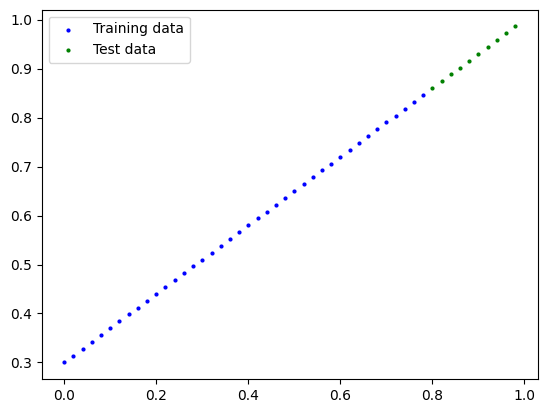

In [5]:
plot_predictions()

In [6]:
# Creating PyTorch Linear Regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias

In [7]:
# Setting manual seed since the parameters are randomly initialized
torch.manual_seed(seed=42)

# Creating linear regression model instance
model_0 = LinearRegressionModel()

# Printing the nn.Module parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
list(model_0.named_parameters())

[('weight',
  Parameter containing:
  tensor([0.3367], requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([0.1288], requires_grad=True))]

In [9]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

Note in both `nn.Module.parameters()` and `nn.Module.named_parameters()` the return values are parameters not the actual tensor within the parameter.

But the `nn.Module.state_dict()` returns the tensor.

In [10]:
# torch.inference_mode() does similar work as torch.no_grad() but the torch.inference_mode() is faster
# compared to torch.no_grad() while `no_grad` excludes operations being tracked by Autograd, 
# `inference_mode` reduces overheads by disabling two Autograd mechanims - version counting and
# metadata tracking. 
# Please see following tweet from PyTorch: https://x.com/PyTorch/status/1437838231505096708?s=20 
with torch.inference_mode():
    y_preds = model_0(X_test)

print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(y_preds)

Number of testing samples: 10
Number of predictions made: 10
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


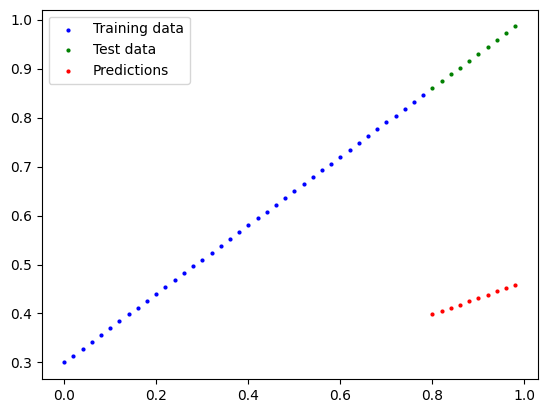

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [13]:
epochs = 100

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(1, epochs):
    model_0.train()
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch:<3} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 10  | MAE Train Loss: 0.20919232070446014 | MAE Test Loss: 0.3598262071609497
Epoch: 20  | MAE Train Loss: 0.09681282937526703 | MAE Test Loss: 0.22817862033843994
Epoch: 30  | MAE Train Loss: 0.0545857734978199 | MAE Test Loss: 0.14967669546604156
Epoch: 40  | MAE Train Loss: 0.04591871052980423 | MAE Test Loss: 0.11538954079151154
Epoch: 50  | MAE Train Loss: 0.04202762991189957 | MAE Test Loss: 0.10030148178339005
Epoch: 60  | MAE Train Loss: 0.0385376438498497 | MAE Test Loss: 0.08928143978118896
Epoch: 70  | MAE Train Loss: 0.035098835825920105 | MAE Test Loss: 0.0810088962316513
Epoch: 80  | MAE Train Loss: 0.03166865184903145 | MAE Test Loss: 0.07342323660850525
Epoch: 90  | MAE Train Loss: 0.028234023600816727 | MAE Test Loss: 0.06515069305896759


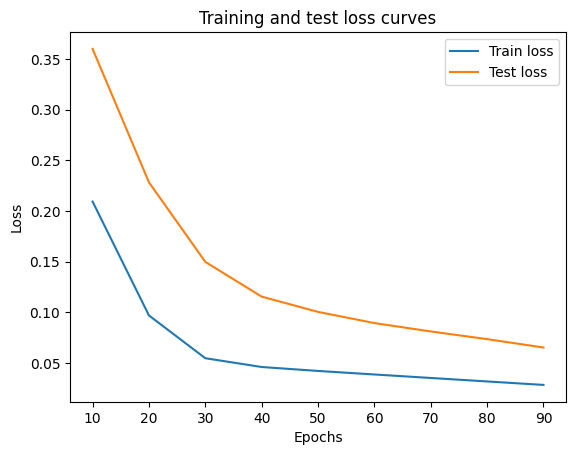

In [14]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [15]:
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print(f"\nAnd the original values for weights and bias are:\nweight: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weight', tensor([0.5766])), ('bias', tensor([0.3518]))])

And the original values for weights and bias are:
weight: 0.7, bias: 0.3


In [16]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.8131],
        [0.8247],
        [0.8362],
        [0.8477],
        [0.8593],
        [0.8708],
        [0.8823],
        [0.8939],
        [0.9054],
        [0.9169]])

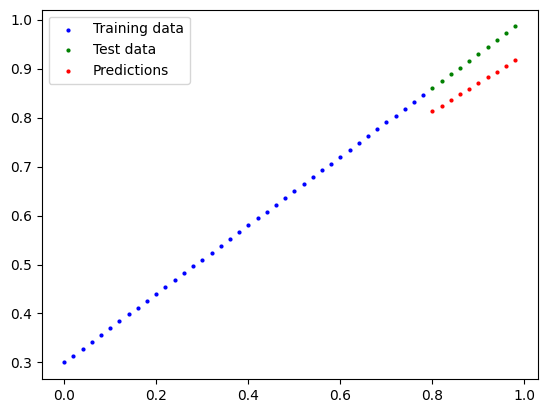

In [17]:
plot_predictions(predictions=y_preds)

In [23]:
torch.manual_seed(seed=42)

epochs = 200
learning_rate = 0.01

epoch_count = []
train_loss_values = []
test_loss_values = []

model_0 = LinearRegressionModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=learning_rate)

for epoch in range(1, epochs):
    model_0.train()
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_preds = model_0(X_test)
        test_loss = loss_fn(test_preds, y_test)

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch:<3} | MAE Train Loss: {loss:.10f} | MAE Test Loss: {test_loss:.10f}")

Epoch: 10  | MAE Train Loss: 0.2091923207 | MAE Test Loss: 0.3598262072
Epoch: 20  | MAE Train Loss: 0.0968128294 | MAE Test Loss: 0.2281786203
Epoch: 30  | MAE Train Loss: 0.0545857735 | MAE Test Loss: 0.1496766955
Epoch: 40  | MAE Train Loss: 0.0459187105 | MAE Test Loss: 0.1153895408
Epoch: 50  | MAE Train Loss: 0.0420276299 | MAE Test Loss: 0.1003014818
Epoch: 60  | MAE Train Loss: 0.0385376438 | MAE Test Loss: 0.0892814398
Epoch: 70  | MAE Train Loss: 0.0350988358 | MAE Test Loss: 0.0810088962
Epoch: 80  | MAE Train Loss: 0.0316686518 | MAE Test Loss: 0.0734232366
Epoch: 90  | MAE Train Loss: 0.0282340236 | MAE Test Loss: 0.0651506931
Epoch: 100 | MAE Train Loss: 0.0247952193 | MAE Test Loss: 0.0568781495
Epoch: 110 | MAE Train Loss: 0.0213667154 | MAE Test Loss: 0.0492924936
Epoch: 120 | MAE Train Loss: 0.0179304071 | MAE Test Loss: 0.0410199575
Epoch: 130 | MAE Train Loss: 0.0144932326 | MAE Test Loss: 0.0334342904
Epoch: 140 | MAE Train Loss: 0.0110647865 | MAE Test Loss: 0.025

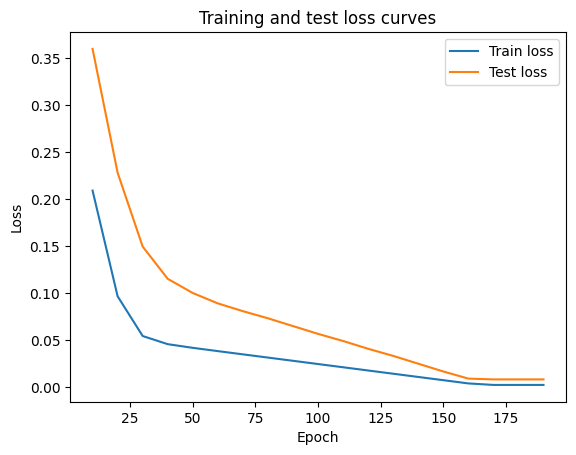

In [26]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [27]:
print(f"The model learned the following values for weight and bias:")
print(model_0.state_dict())
print(f"\nAnd the original values for weight and bias are:\nweight: {weight}, bias: {bias}")

The model learned the following values for weight and bias:
OrderedDict([('weight', tensor([0.6951])), ('bias', tensor([0.2993]))])

And the original values for weight and bias are:
weight: 0.7, bias: 0.3


In [28]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

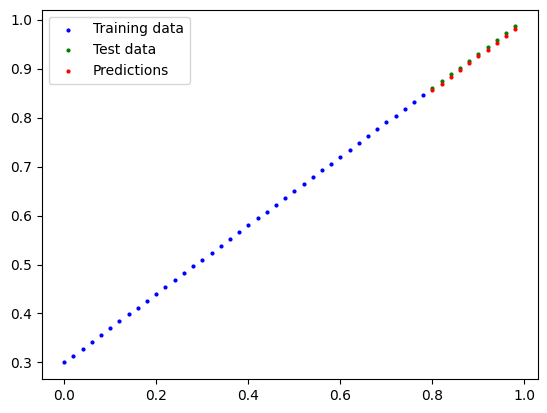

In [29]:
plot_predictions(predictions=y_preds)